In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import wrangle #acquire, prep and clean library
import env
import explore

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

from math import sqrt
from datetime import date #remove for final project as it is in the wrangle.py

# Notes

# Executive Summary

- Bathrooms, bedrooms and square footage where the primary features that drove tax values followed by location.
- With more time I would like to have explore more single units, age and property type.

# Planning

- I want to find out if tax values differ for each of the following scenarios:
    - tax value to number of bathrooms
    - tax value to number of bedrooms
    - tax value to square footage
    - tax value to county

# Data Acquisition

- Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

In [2]:
df = wrangle.get_zillow_data()
df.head(2)

,bathroomcnt,bedroomcnt,fips,yearbuilt,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,2.0,3.0,6037.0,1923.0,205123.0,2627.48,1316.0
1,2.0,3.0,6037.0,1970.0,136104.0,2319.90,1458.0


##### Acquired dataset
1. Queried single family homes from "hot months" May to August 2017 as stated in the project scenario.

# Data Preparation

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe().T

In [3]:
df['age'] = date.today().year - df.yearbuilt
df['tax_rate'] = (df['taxamount'] / df['taxvaluedollarcnt'])
df = df.drop(columns=['yearbuilt', 'taxamount'])
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet":"square_feet",
                        "taxvaluedollarcnt":"tax_value", "fips":"county_code"})

df['tax_rate'] = df.tax_rate.fillna(value = df['tax_rate'].mean())
df['tax_value'] = df.tax_value.fillna(value = df['tax_value'].mean())
df['square_feet'] = df.square_feet.fillna(value = df['square_feet'].mean())
df['age'] = df.age.fillna(value = df['age'].mean())

#converts floats to int 
convert_dict_int = {'county_code': int, 'bathrooms': int, 'bedrooms': int, 'tax_value':int, 'square_feet':int, 
                    'age':int}
df = df.astype(convert_dict_int)


In [ ]:

df.head()

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
#prior to removing outliers
#had to add 'transaction_date' to the drop column within the function
wrangle.get_hist(df)

In [ ]:
#prior to removing outliers
wrangle.get_box(df)

In [4]:
#remove outliers
k = 1.5
col_list = ['bathrooms', 'bedrooms', 'tax_value', 'tax_rate', 'square_feet', 'age']
df = wrangle.remove_outliers(df, k , col_list)
df.head()

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate
0,2,3,6037,205123,1316,98,0.012809
2,1,2,6037,35606,1421,110,0.015270
3,3,4,6059,880456,2541,18,0.011153
4,2,3,6037,107110,1491,66,0.013064
5,2,3,6037,614000,1650,72,0.012497


In [ ]:
#after removing outliers
wrangle.get_hist(df)

In [ ]:
#after removing outliers
wrangle.get_box(df)

##### NOTES

1. SQL zillow dataset
2. property type - Single Family - 261
3. .shape (2152863, 61)
4. After initial data acquisition .shape (2152863, 16)
    - From initial acquisition I kept the following columns:
    - parcelid, basementsqft, bathroomcnt, bedroomcnt, fips, garagecarcnt, garagetotalsqft, lotsizesquarefeet, poolcnt, poolsizesum, roomcnt, unitcnt, yearbuilt, numberofstories, taxvaluedollarcnt, taxamount
5. Dropped (based on qty of nulls): basementsqft, garagetotalsqft, poolcnt, poolsizesum, unitcnt, numberofstories, roomcnt
6. Final .shape (2152985, 11)
7. Drop duplicates (2152982, 11) 
8. Fill in nulls (as identified in wrangle.py)
9. Drop columns
10. Visualize
11. Remove outliers
12. After prep'd data I queried "hot months" from sql
    - shape after query (28124, 12)
    - null counts show different numbers and prep function will need to be modified
    - no change in shape after dropping duplicates
    - modified prep function
    - modified outliersw
    
##### NOTES on Project Guidance
- The below, prior to data exploration, is built to project guidance.

## MVP

# Split data

In [5]:
train, validate, test = wrangle.train_validate_test_split(df)
print(f'train: {train.shape}')
print(f'validate: {validate.shape}')
print(f'test: {test.shape}')

train: (12348, 7)
validate: (5292, 7)
test: (4410, 7)


# Data Exploration

1. What are the takeaways about the drivers of single unit property values?
    - County code 6037 makes up 61.17 percent of "hot_months" properties.
    - Three bedrooms, 2 bath homes of an average of 1745 make up the majority of properties.
    - Average tax value for these home is 408,247 dollars.
    - Average ages of the homes is 58 years.
    - Average tax rate is 1.25 percent.

2. Visualizations to support main points.

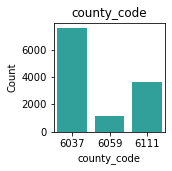

      county_code  Count  Percent
6037         6037   7548    61.13
6059         6111   3611    29.24
6111         6059   1189     9.63


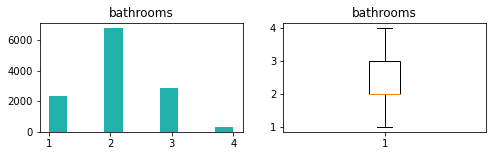

count    12348.000000
mean         2.099206
std          0.722739
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: bathrooms, dtype: float64


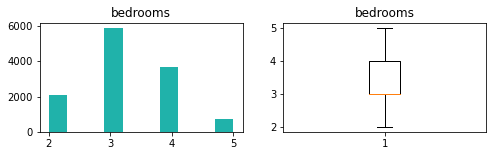

count    12348.000000
mean         3.244250
std          0.798544
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: bedrooms, dtype: float64


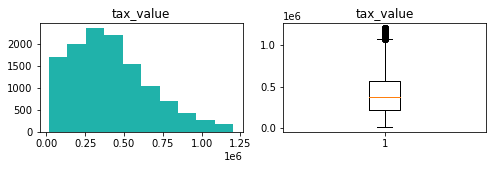

count    1.234800e+04
mean     4.163668e+05
std      2.525879e+05
min      1.608400e+04
25%      2.229975e+05
50%      3.811420e+05
75%      5.644125e+05
max      1.204898e+06
Name: tax_value, dtype: float64


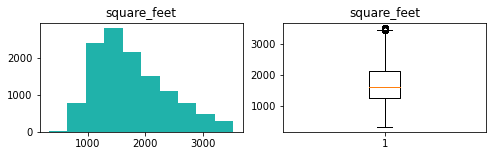

count    12348.000000
mean      1753.299563
std        623.510051
min        326.000000
25%       1273.000000
50%       1628.500000
75%       2142.000000
max       3524.000000
Name: square_feet, dtype: float64


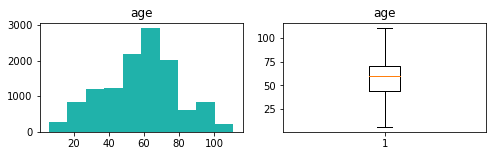

count    12348.000000
mean        58.181406
std         21.069838
min          6.000000
25%         44.000000
50%         60.000000
75%         71.000000
max        111.000000
Name: age, dtype: float64


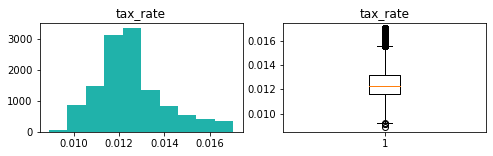

count    12348.000000
mean         0.012511
std          0.001496
min          0.008908
25%          0.011587
50%          0.012262
75%          0.013175
max          0.017044
Name: tax_rate, dtype: float64


In [6]:
explore.explore_univariate(train, cat_vars = ['county_code'], quant_vars = ['bathrooms', 'bedrooms', 'tax_value', 
                                                                            'square_feet', 'age', 'tax_rate'])

# Initial Hypothesis and Testing

### Bivariate

- County Code 6059 has the tax value at 468,487 dollars, followed by 6111 at 449,845 and 6037 at 386,158
- Tax values are higher for homes with 4 baths 635,958
- Tax values are higher for homes with 5 bedrooms 529,151

##### Hypothesis

- Do homes in 6059 have haigher tax values then the rest of the population?
- Do Homes with four baths have a higher tax value then the rest of the populations?
- Do home with five bedrooms have a higher tax value then the rest of the population?
- Do 5 bedroom/4 bath homes in 6059 have higher tax value then the rest of the population?


county_code vs tax_value


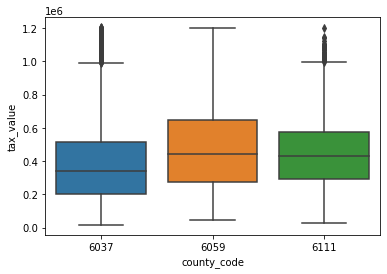

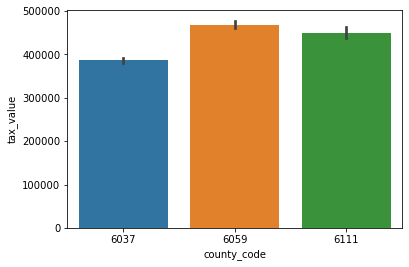

-------------------------------
Mean tax_value by county_code:  
county_code
6037    386158.489931
6059    468487.031847
6111    449845.395290
Name: tax_value, dtype: float64

bathrooms vs tax_value


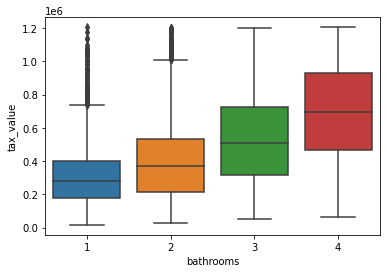

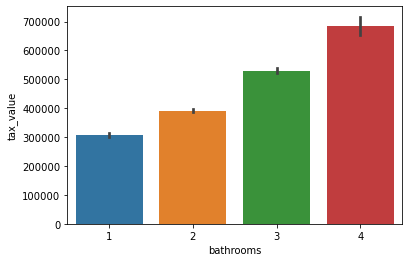

-------------------------------
Mean tax_value by bathrooms:  
bathrooms
1    307513.756838
2    391878.319510
3    530501.316316
4    685958.345345
Name: tax_value, dtype: float64

bedrooms vs tax_value


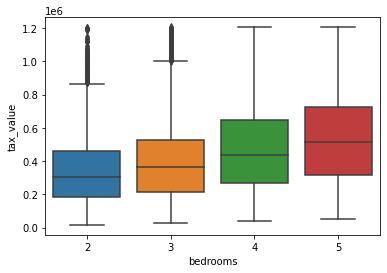

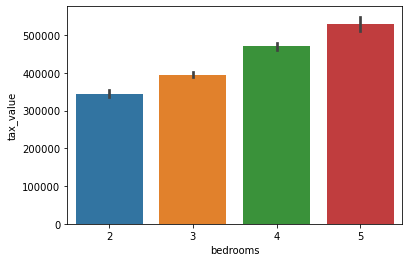

-------------------------------
Mean tax_value by bedrooms:  
bedrooms
2    345094.749880
3    394369.703306
4    470058.414879
5    529151.866197
Name: tax_value, dtype: float64



In [7]:
#exploring split
#FIPS VS TAX_value
explore.exp_bivariate_categorical('tax_value', ['county_code', 'bathrooms', 'bedrooms'], train)

### Multivariate

- Age of the home does not really play into the tax value of the home.
    - Homes between 40-75 years old range 
- Linear correlation between tax value and square footage of the home.
    - It is a small correlation, but noticeable (future feature not MVP but include in body and conclusion)

age vs tax_value


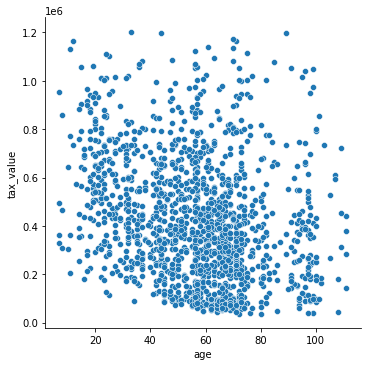

-------------------------------
Correlation between age and tax_value:  -0.2626432723404882
P value:  4.372206181850314e-25

square_feet vs tax_value


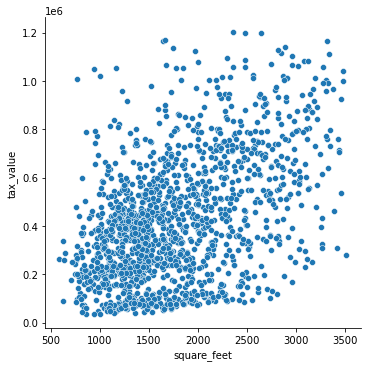

-------------------------------
Correlation between square_feet and tax_value:  0.47000547434563056
P value:  2.767930055574024e-83



In [10]:
explore.exp_bivariate_continuous('tax_value', ['age', 'square_feet'], train.sample(1500))

# Hypothesis Testing
    - Do homes in 6059 have haigher tax values then the rest of the population?
    - Do Homes with four baths have a higher tax value then the rest of the populations?
    - Do home with five bedrooms have a higher tax value then the rest of the population?
    - Do 5 bedroom/ 4 bath homes in 6059 have higher tax value then the rest of the population?
    - Is the a positive linear correlation between tax value and square footage of the home.
    
I used a .05 alpha to test hypothesis.

In [13]:
alpha = .05

1. Do homes in 6059 have a higer tax values? (chi2)
    - Null: Tax value is independent of homes in 6059.
    - Alternate: Tax value is dependent of homes in 6059.

In [37]:
Null = 'Tax value is independent of homes in 6059.'
Alternate = 'Tax value is dependent of homes in 6059.'

observed = pd.crosstab(train.tax_value, train.county_code == 6059)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 11219.2770
p     = 0.0000


We reject the null and accept the alternate: Tax value is dependent of homes in 6059.


2. Do homes with three or more baths have a higher tax value? (chi2)
    - Null: Tax value is independentt of three or more baths.
    - Alternate: Tax value is dependent on three or more baths.

In [36]:
Null = 'Tax value is independentt of three or more bathrooms.'
Alternate = 'Tax value is dependent on three or more bathrooms.'

observed = pd.crosstab(train.tax_value, train.bathrooms >= 3)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 11051.7334
p     = 0.0010


We reject the null and accept the alternate: Tax value is dependent on three or more bathrooms.


3. Do home with four or more bedrooms have a higher tax value? (chi2)
    - Null: Tax value is independentt of four or more bedrooms.
    - Alternate: Tax value is dependent on four or more bedrooms.

In [35]:
Null = 'Tax value is independent of four or more bedrooms.'
Alternate = 'Tax value is dependent on four or more bedrooms.'

observed = pd.crosstab(train.tax_value, train.bedrooms >= 4)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 10857.0250
p     = 0.0373


We reject the null and accept the alternate: Tax value is dependent on four or more bedrooms.


4. Linear correlation between tax value and square footage of the home. (pearsonr)
    - Null: Tax value and square footage are NOT lineraly correlated.
    - Alternate: Tax value and square footage are lineraly correlated.

In [34]:
Null = 'Tax value and square footage are NOT lineraly correlated.'
Alternate = 'Tax value and square footage are lineraly correlated.'

corr, p = stats.pearsonr(train.tax_value, train.square_feet)

print(f'chi^2 = {corr:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.4500
p     = 0.0000


We reject the null and accept the alternate: Tax value and square footage are lineraly correlated.


AttributeError: 'list' object has no attribute 'get'

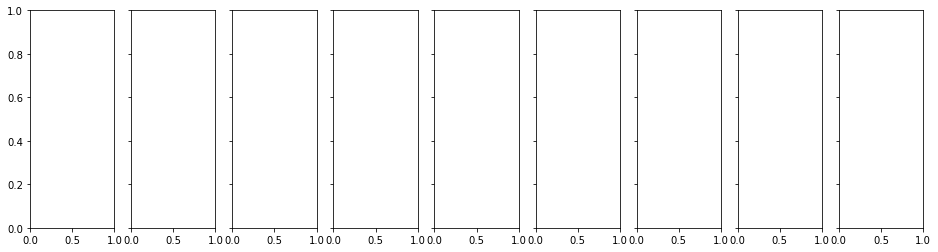

In [39]:
explore.explore_multivariate(['square_feet', 'age'], ['county_code', 'bedrooms', 'bathrooms'], 'tax_value', train.sample(1000))

# Modeling